In [1]:
import glob
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from consts import (
    CORECEPTOR_CMAP,
    CORECEPTOR_ORDER,
    DRUG_CMAP,
    DRUG_ORDER,
    HALF_PAGE_FIGSIZE,
    MODEL_CMAP,
    MODEL_FANCY_NAMES,
    MODEL_FANCY_ORDER,
    TASK_FANCY_NAMES,
    TASK_FANCY_ORDER,
    TISSUE_CMAP,
    TISSUE_ORDER,
)
from scipy.stats import ttest_rel
from statannotations.stats.StatTest import StatTest
from utils import FilteredAnnotator, model_test_pairs, parse_model_results

plt.style.use("mike.mplstyle")

In [2]:
try:
    files = [str(f) for f in snakemake.input['model_results']]
except NameError:
    pattern = "../models/*/*/best.yaml"
    files = glob.glob(pattern)

In [3]:
df = parse_model_results(files).replace({'task':TASK_FANCY_NAMES, 'model': MODEL_FANCY_NAMES})
df.head()

,fold,model,prot,task,DS,metric,field,value
0,0,TF-IDF,PR,Protease\nResistance,Full,acc,FPV,0.857143
1,0,TF-IDF,PR,Protease\nResistance,Full,auc,FPV,0.935297
2,0,TF-IDF,PR,Protease\nResistance,Full,f1,FPV,0.811245
3,0,TF-IDF,PR,Protease\nResistance,Full,precision,FPV,0.795276
4,0,TF-IDF,PR,Protease\nResistance,Full,recall,FPV,0.827869


In [4]:
def mean_std(vals):
    return f"{100*vals.mean():0.1f}% ({100*vals.std():0.1f})"


piv_data = pd.pivot_table(
    df, index=["task", "model"], columns="metric", values="value", aggfunc=mean_std
)
col_order = ["precision", "recall", "acc", "auc"]
row_order = pd.MultiIndex.from_tuples(product(TASK_FANCY_ORDER, MODEL_FANCY_ORDER))

wanted_piv = piv_data.loc[row_order, col_order]
wanted_piv

metric                              precision        recall           acc  \
Protease\nResistance Null-Model   43.4% (7.6)   43.6% (7.9)   51.7% (2.7)   
                     TF-IDF       87.2% (5.0)   92.4% (4.9)   91.3% (2.8)   
                     Prot-BERT   81.8% (10.1)  84.0% (20.7)   84.3% (9.8)   
                     HIV-BERT     85.5% (9.0)   88.5% (4.3)   88.4% (3.2)   
Coreceptor           Null-Model  57.7% (36.3)  58.0% (35.8)  74.0% (11.9)   
                     TF-IDF       92.7% (4.4)  82.0% (18.2)   92.4% (2.9)   
                     Prot-BERT    91.0% (6.6)  81.5% (15.6)   91.2% (2.3)   
                     HIV-BERT     91.7% (6.0)  84.5% (13.5)   92.5% (2.2)   
Tissue               Null-Model  14.1% (15.7)  14.2% (15.6)  79.3% (13.4)   
                     TF-IDF      81.8% (19.7)  20.6% (20.8)   88.6% (9.6)   
                     Prot-BERT    6.1% (17.5)  11.1% (31.8)  86.4% (12.4)   
                     HIV-BERT    53.4% (34.0)  33.3% (25.4)   89.1% (9.9)   

metric                                    auc  
Protease\nResistance Null-Model   49.9% (2.3)  
                     TF-IDF       97.0% (1.4)  
                     Prot-BERT   89.1% (12.0)  
                     HIV-BERT     94.3% (2.4)  
Coreceptor           Null-Model   49.7% (2.1)  
                     TF-IDF       92.5% (2.6)  
                     Prot-BERT    91.6% (3.0)  
                     HIV-BERT     92.4% (2.8)  
Tissue               Null-Model   49.7% (1.5)  
                     TF-IDF       85.0% (6.7)  
                     Prot-BERT    52.1% (7.2)  
                     HIV-BERT     81.6% (7.4)

In [5]:
print("Table 1")
print(wanted_piv.to_markdown())

Table 1
|                                        | precision    | recall       | acc          | auc          |
|:---------------------------------------|:-------------|:-------------|:-------------|:-------------|
| ('Protease\nResistance', 'Null-Model') | 43.4% (7.6)  | 43.6% (7.9)  | 51.7% (2.7)  | 49.9% (2.3)  |
| ('Protease\nResistance', 'TF-IDF')     | 87.2% (5.0)  | 92.4% (4.9)  | 91.3% (2.8)  | 97.0% (1.4)  |
| ('Protease\nResistance', 'Prot-BERT')  | 81.8% (10.1) | 84.0% (20.7) | 84.3% (9.8)  | 89.1% (12.0) |
| ('Protease\nResistance', 'HIV-BERT')   | 85.5% (9.0)  | 88.5% (4.3)  | 88.4% (3.2)  | 94.3% (2.4)  |
| ('Coreceptor', 'Null-Model')           | 57.7% (36.3) | 58.0% (35.8) | 74.0% (11.9) | 49.7% (2.1)  |
| ('Coreceptor', 'TF-IDF')               | 92.7% (4.4)  | 82.0% (18.2) | 92.4% (2.9)  | 92.5% (2.6)  |
| ('Coreceptor', 'Prot-BERT')            | 91.0% (6.6)  | 81.5% (15.6) | 91.2% (2.3)  | 91.6% (3.0)  |
| ('Coreceptor', 'HIV-BERT')             | 91.7% (6.0)  | 84.5% (

In [6]:
piv_data = pd.pivot_table(
    df, index=["task", "model"], columns="metric", values="value", aggfunc=mean_std
)

try:
    piv_data.to_excel(str(snakemake.output['model_table']))
except NameError:
    piv_data.to_excel("Table1-model_results.xlsx")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tissue_Prot-BERT vs. Tissue_HIV-BERT: Paired T-test with Bonferroni correction, P_val:2.858e-06 Stat=-6.223e+00
Coreceptor_Prot-BERT vs. Coreceptor_HIV-BERT: Paired T-test with Bonferroni correction, P_val:4.747e-02 Stat=-4.110e+00
Tissue_Null-Model vs. Tissue_TF-IDF: Paired T-test with Bonferroni correction, P_val:5.421e-17 Stat=-1.439e+01
Protease
Resistance_Null-Model vs. Protease
Resistance_TF-IDF: Paired T-test with Bonferroni correction, P_val:4.281e-18 Stat=-3.782e+01
Coreceptor_Null-Model vs. Coreceptor_TF-IDF: Paired T-test with Bonferroni correction, P_val:2.872e-03 Stat=-6.196e+00
Tissue_TF-IDF vs. Tissue_Prot-BERT: Paired T-test with Bonferroni correction, P_val:6.689e-04 Stat=4.587e+00
Protease
Resistance_TF-IDF vs. Protease
Resistance_HIV-BERT: Paired T-test with Bonferroni correction, P_val:3.

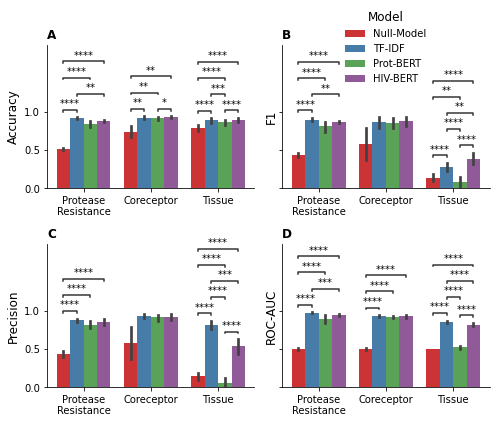

In [7]:
common_args = dict(
    y="value",
    x="task",
    order=TASK_FANCY_ORDER,
    hue="model",
    hue_order=MODEL_FANCY_ORDER,
)

FANCY_METRIC_LABELS = {
    "f1": "F1",
    "acc": "Accuracy",
    "auc": "ROC-AUC",
    "precision": "Precision",
}
METRIC_ORDER = ["acc", "f1", "precision", "auc"]

pairs = model_test_pairs(TASK_FANCY_ORDER)
stat_test = StatTest(ttest_rel, "Paired T-test", "paired")

with sns.color_palette(MODEL_CMAP):

    fig, axs = plt.subplots(2, 2, figsize=HALF_PAGE_FIGSIZE, sharey=True)
    for ax, met, title in zip(axs.flatten(), METRIC_ORDER, "ABCD"):

        met_df = df.query(f'metric == "{met}"')

        sns.barplot(data=met_df, ax=ax, **common_args)
        ax.set_ylim(0, 1.25)
        annotator = FilteredAnnotator(ax, pairs, data=met_df, **common_args)
        annotator.configure(
            test=stat_test,
            text_format="star",
            loc="inside",
            comparisons_correction="bonf",
        )
        annotator.apply_test().annotate()
        if met != "f1":
            ax.legend([], [], frameon=False)
        else:
            ax.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, 1.3))

        ax.set_yticks([t for t in ax.get_yticks() if t <= 1])
        ax.set_ylabel(FANCY_METRIC_LABELS[met])
        ax.set_xlabel("")
        ax.set_title(title)

        sns.despine(ax=ax)

fig.tight_layout()

In [8]:
try:
    fig.savefig(str(snakemake.output['model_group']), dpi=300)
except NameError:
    fig.savefig("Fig3-model_group-high.png", dpi=300)

In [9]:
def plot_model(task, ax, metric="auc", hue_order=None):

    mask = (df["task"] == task) & (df["metric"] == metric)
    common_args = dict(
        data=df.loc[mask],
        y="value",
        hue="field",
        hue_order=hue_order,
        x="model",
        order=MODEL_FANCY_ORDER,
    )
    sns.barplot(ax=ax, **common_args)

    pairs = model_test_pairs(hue_order, transpose=True)
    annotator = FilteredAnnotator(ax, pairs, **common_args)
    annotator.configure(
        test=stat_test, text_format="star", loc="inside", comparisons_correction="bonf"
    )

    annotator.apply_test().annotate()
    ax.set_xlabel("")
    return annotator

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HIV-BERT_IDV vs. HIV-BERT_SQV: Paired T-test with Bonferroni correction, P_val:1.856e-02 Stat=9.206e+00
TF-IDF_IDV vs. TF-IDF_SQV: Paired T-test with Bonferroni correction, P_val:2.767e-02 Stat=8.296e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TF-IDF_CCR5 vs. TF-IDF_CXCR4: Paired T-test with Bonferroni correction, P_val:3.720e-02 Stat=4.701e+00
Prot-BERT_CCR5 vs. Prot-BERT_CXCR4: Paired T-test with Bonferroni correction, P_val:2.202e-02 Stat=5.450e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HIV-BERT_CNS vs. HIV-BERT_breast-milk: Pa

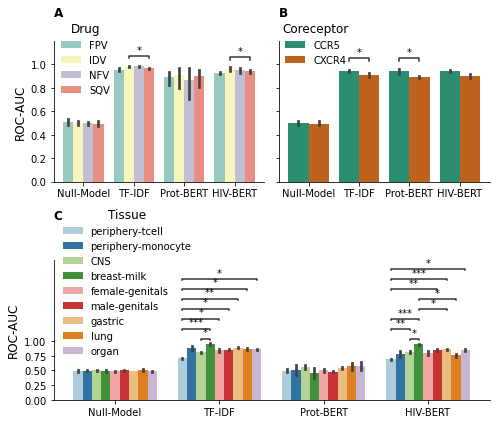

In [10]:
fig, axs = plt.subplots(2, 2, figsize=HALF_PAGE_FIGSIZE, sharey=True)
axs = axs.flatten()

with sns.color_palette(DRUG_CMAP):
    resist_ax = axs[0]
    plot_model("Protease\nResistance", resist_ax, metric="auc", hue_order=DRUG_ORDER)
    resist_ax.set_ylabel("ROC-AUC")
    resist_ax.legend(loc="upper left", title="Drug", bbox_to_anchor=(-0.0075, 1.2))
    resist_ax.set_title('A', pad=25)
    sns.despine(ax=resist_ax)

with sns.color_palette(CORECEPTOR_CMAP):
    trop_ax = axs[1]
    plot_model("Coreceptor", trop_ax, metric="auc", hue_order=CORECEPTOR_ORDER)
    trop_ax.legend(loc="upper left", title="Coreceptor", bbox_to_anchor=(-0.025, 1.2))
    sns.despine(ax=trop_ax)
    trop_ax.set_ylabel("")
    trop_ax.set_title('B', pad=25)

body_ax = plt.subplot(212)

with sns.color_palette(TISSUE_CMAP):
    plot_model("Tissue", body_ax, metric="auc", hue_order=TISSUE_ORDER)
    body_ax.set_ylabel("ROC-AUC")
    body_ax.legend(loc="lower left", title="Tissue", ncol=1, bbox_to_anchor=(0, 0.25))
    body_ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    body_ax.set_title('C', pad=40)
    sns.despine(ax=body_ax)

fig.tight_layout()

In [11]:
try:
    fig.savefig(str(snakemake.output['model_results']), dpi=300)
except NameError:
    fig.savefig("Fig4-model_results-high.png", dpi=300)